In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import norm
from numpy import log, exp, sqrt



## Hypotheses 

In [2]:
#Market information
r= 0.08    # Risk-free rate

# Share specific information
S_0= 100     # Today's stock price
sigma= 0.3 # Annualized volatility of the stock

# Option information
K= 100      # Strike/Exercise price
barrier = 150 # up and out barrier
T= 1     # Maturity (in years)

# Firm information
V_0 = 200 # Initial value of the firm
sigma_firm = 0.25 # Volatility of the counterparty firm's value
debt = 175 # counterparty debt due in one year
rho = 0.2 # correlation between the counterparty and the stock
recovery_rate = 0.25 # recovery rate with the counterparty




## Price of the European Call Option

In [3]:
def bs_call(S,X,T,rf,sigma):
    """
       Returns: Call value under Black-Schole-Merton option model
       Format   : bs_call(S,X,T,r,sigma)
               S: current stock price
               X: exercise price
               T: maturity date in years
              rf: risk-free rate (continusouly compounded)
           sigma: volatiity of underlying security 
    """    
   
    d1=(log(S/X)+(rf+sigma*sigma/2.)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    return S*norm.cdf(d1)-X*exp(-rf*T)*norm.cdf(d2)

In [4]:
print(f"The price of the european call option is {bs_call(S_0, K,T, r,sigma) :.2f}")

The price of the european call option is 15.71


## Helper Functions

In [5]:
def terminal_value(S_0: float, risk_free_rate: float, sigma: float, Z:float, T:float) -> float:
    """Generates the terminal share price given some random normal values, Z"""
    return S_0 * np.exp((risk_free_rate-sigma**2/2)*T + sigma*np.sqrt(T) * Z)

In [6]:
def share_path(S_0, risk_free_rate, sigma, Z, dT):
    return S_0*np.exp(np.cumsum((risk_free_rate-sigma**2/2)*dT + sigma*np.sqrt(dT)*Z,1))

In [7]:
def discounted_call_payoff(S_T,K,risk_free_rate,T):

    """Function for evaluating the discounted payoff of call in Monte Carlo Estimation"""

    return np.exp(-risk_free_rate*T)*np.maximum(S_T-K,0)

In [8]:
def call_payoff(S_T,K):

    """Function for evaluating the call price at terminal time in Monte Carlo Estimation"""

    return np.maximum(S_T-K,0)

## Pricing of the Up and Out Call Option

In [9]:
def generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 20, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    share_price_path = pd.DataFrame(share_path(S0, risk_free, sigma, Z=corr_norm_matrix[:,0,], dT=T/timesteps))
    share_price_path = share_price_path.transpose()

    firm_price_path = pd.DataFrame(share_path(v_0, risk_free, sigma_firm, Z=corr_norm_matrix[:,1,], dT=T/timesteps))
    firm_price_path = firm_price_path.transpose()

    return [share_price_path,firm_price_path]

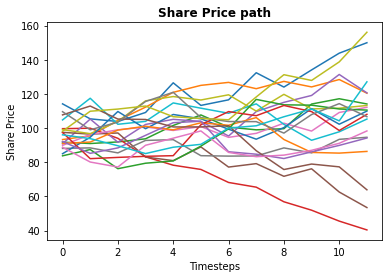

In [10]:
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

share_and_firm_price_path = generate_share_and_firm_price(S_0, V_0, r, sigma, sigma_firm, rho, T) 
share_price_path = share_and_firm_price_path[0]

ax = share_price_path.plot(legend=False)
ax.set(xlabel='Timesteps', ylabel='Share Price')
ax.set_title('Share Price path', fontdict=fontdict)

plt.show();

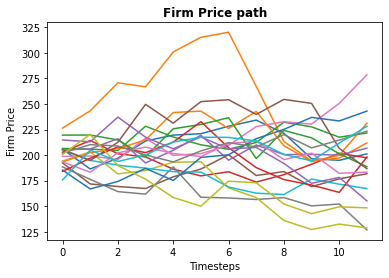

In [11]:
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

share_and_firm_price_path = generate_share_and_firm_price(S_0, V_0, r, sigma, sigma_firm, rho, T) 
firm_price_path = share_and_firm_price_path[1]

ax = firm_price_path.plot(legend=False)
ax.set(xlabel='Timesteps', ylabel='Firm Price')
ax.set_title('Firm Price path', fontdict=fontdict)

plt.show();

In [12]:
def up_and_out_call(s0,x,T,r,sigma,n_simulation,barrier, n_steps=12):
    """
        Returns: Call value of an up-and-out barrier option with European call
    """
    #n_steps= 12 # Define number of steps.
    dt = T/n_steps
    total=0
    for _ in range(n_simulation):
        sT=s0
        out=False
        for _ in range(int(n_steps)):
            e= np.random.normal()
            sT*=np.exp((r-0.5*sigma**2)*dt+sigma*e*np.sqrt(dt))
            if sT>barrier:
                out=True

        if not out:
            total+=bs_call(s0,x,T,r,sigma)

    return total/n_simulation

In [13]:
sims=50_000

up_and_out_call_price = up_and_out_call(S_0, K, T, r, sigma, sims, barrier)

print(f"The price of the up and out call option is : {up_and_out_call_price:.2f}")

The price of the up and out call option is : 13.20


## Price of the european Up and In call


In [14]:
vanilla_call_price = bs_call(S_0, K, T, r, sigma)
up_and_in_call_price = vanilla_call_price - up_and_out_call_price

print(f"The price of the up and in call is {up_and_in_call_price:.2f}")

The price of the up and in call is 2.51


## Price the up and out call options for different strikes



In [15]:
barrier_dicts = {X: up_and_out_call(S_0, X, T, r, sigma, sims, barrier) for X in range(85,120,5)}

In [16]:
import pandas as pd

up_out_calls_df = pd.DataFrame.from_dict(barrier_dicts, orient='index', columns=['Price'])
up_out_calls_df

,Price
85,20.825762
90,17.950319
95,15.495512
100,13.205044
105,11.219781
110,9.482196
115,7.964428


## Monte Carlo estimates of default free value of the option and CVA


In [17]:
def up_and_out_call_cva(sT:np.array,x:float,barrier:float) -> np.array:
    """
        sT: array of terminal values generated by a montecarlo simulation
        Returns: Array of an up-and-out barrier option with European call.
    """
    return 0 if any(sT)>barrier else call_payoff(sT,x)

In [18]:
corr_tested = np.linspace(-1,1,20)
cva_estimates = np.zeros(len(corr_tested))
cva_std = np.zeros(len(corr_tested))

for i in range(len(corr_tested) ):

    correlation = corr_tested[i]

    if correlation in [1, -1]:
        norm_vec_0 = norm.rvs(size = sims)
        norm_vec_1 = correlation*norm_vec_0
        corr_norm_matrix = np.array([norm_vec_0,norm_vec_1])

    else:
        corr_matrix = np.array([[1,correlation],[correlation,1]])
        norm_matrix = norm.rvs(size = np.array([2,50000]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix) ,norm_matrix)

    term_stock_val = terminal_value(S_0,r,sigma,corr_norm_matrix[0,],T)

    call_val = up_and_out_call_cva(term_stock_val, K, barrier)

    term_firm_val = terminal_value(V_0, r, sigma_firm, corr_norm_matrix[1,], T)
    amount_lost = np.exp(-r*T)*(1-recovery_rate)*(term_firm_val < debt)*call_val
    cva_estimates[i] = np.mean(amount_lost)

    cva_std[i] = np.std(amount_lost) /np.sqrt(50000)


## Monte Carlo estimates for the price of the option incorporating the default free value of the option and the the CVA

In [19]:
#Code to calculate default probability
d_1 = (np.log(V_0/debt)+(r + sigma_firm**2/2)*(T))/(sigma_firm*np.sqrt(T) )
d_2 = d_1 - sigma_firm*np.sqrt(T)

default_prob = norm.cdf(-d_2)

#uncorrelated cva
uncorr_cva = (1 - recovery_rate) * default_prob * call_val


In [20]:
default_free_option_value = call_val - uncorr_cva
monte_carlo_up_out_call_price = np.mean(default_free_option_value)
print(f"The monte carlo estimate of the default free value of the up and out call is: {monte_carlo_up_out_call_price:.1f}")


The monte carlo estimate of the default free value of the up and out call is: 14.0
